In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
39690,NaN,NaN,International,2020-08-24,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39691,NaN,NaN,International,2020-08-25,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39692,NaN,NaN,International,2020-08-26,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


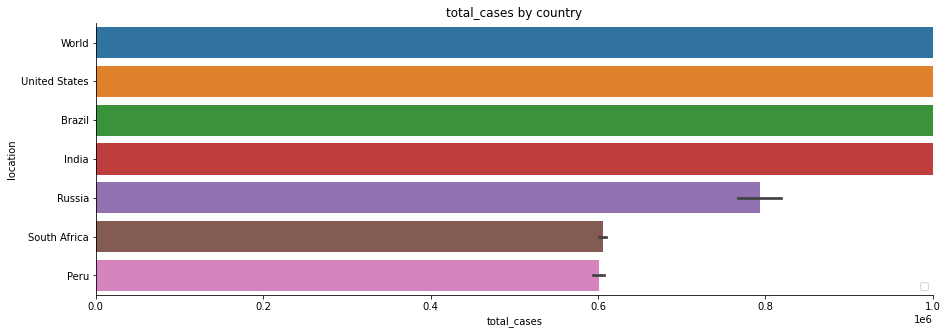

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


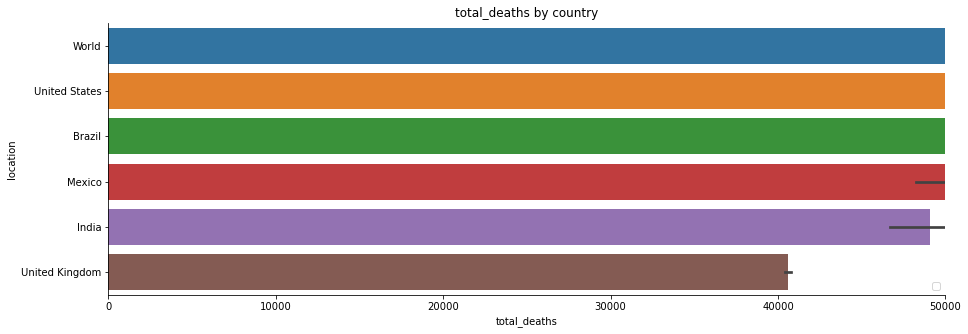

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


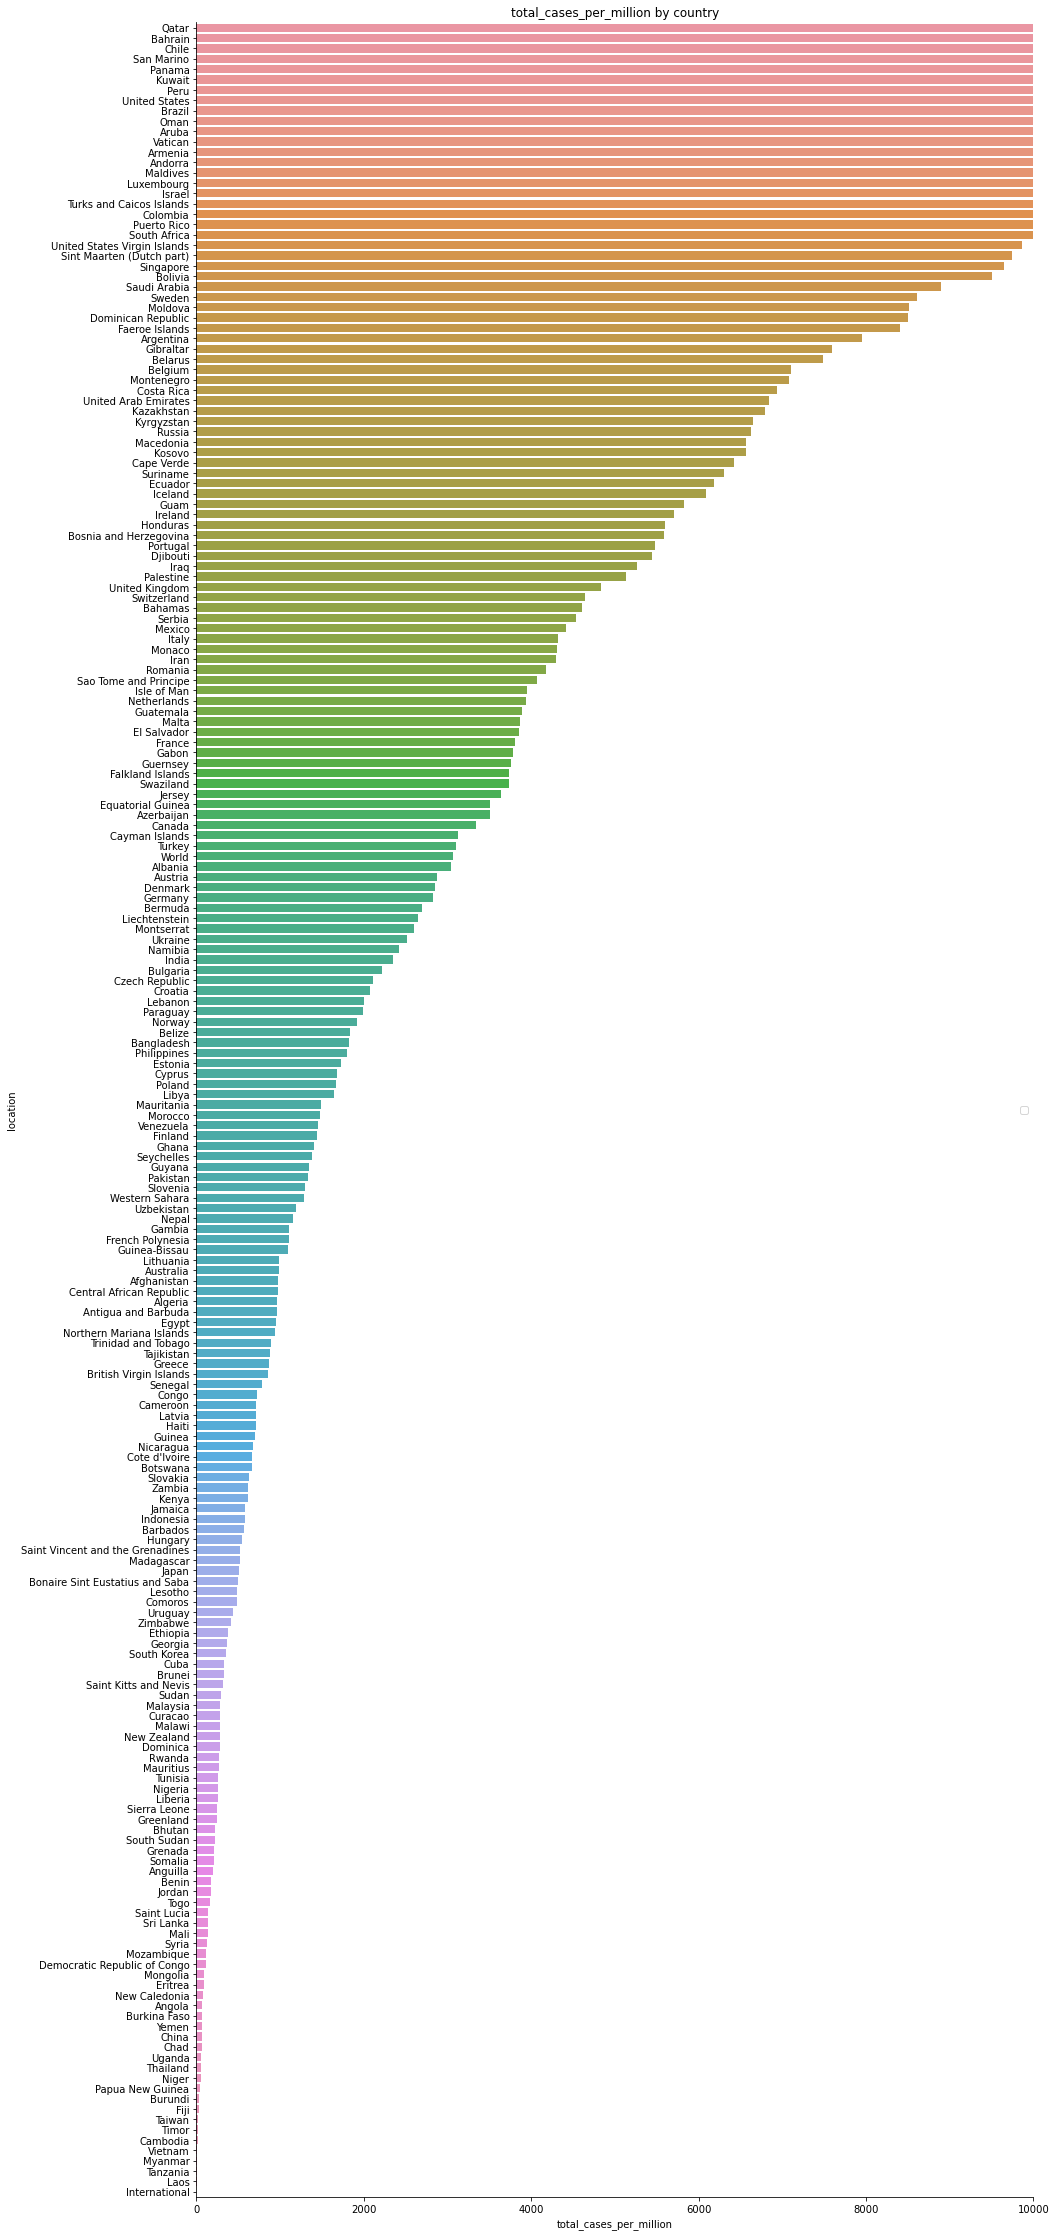

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


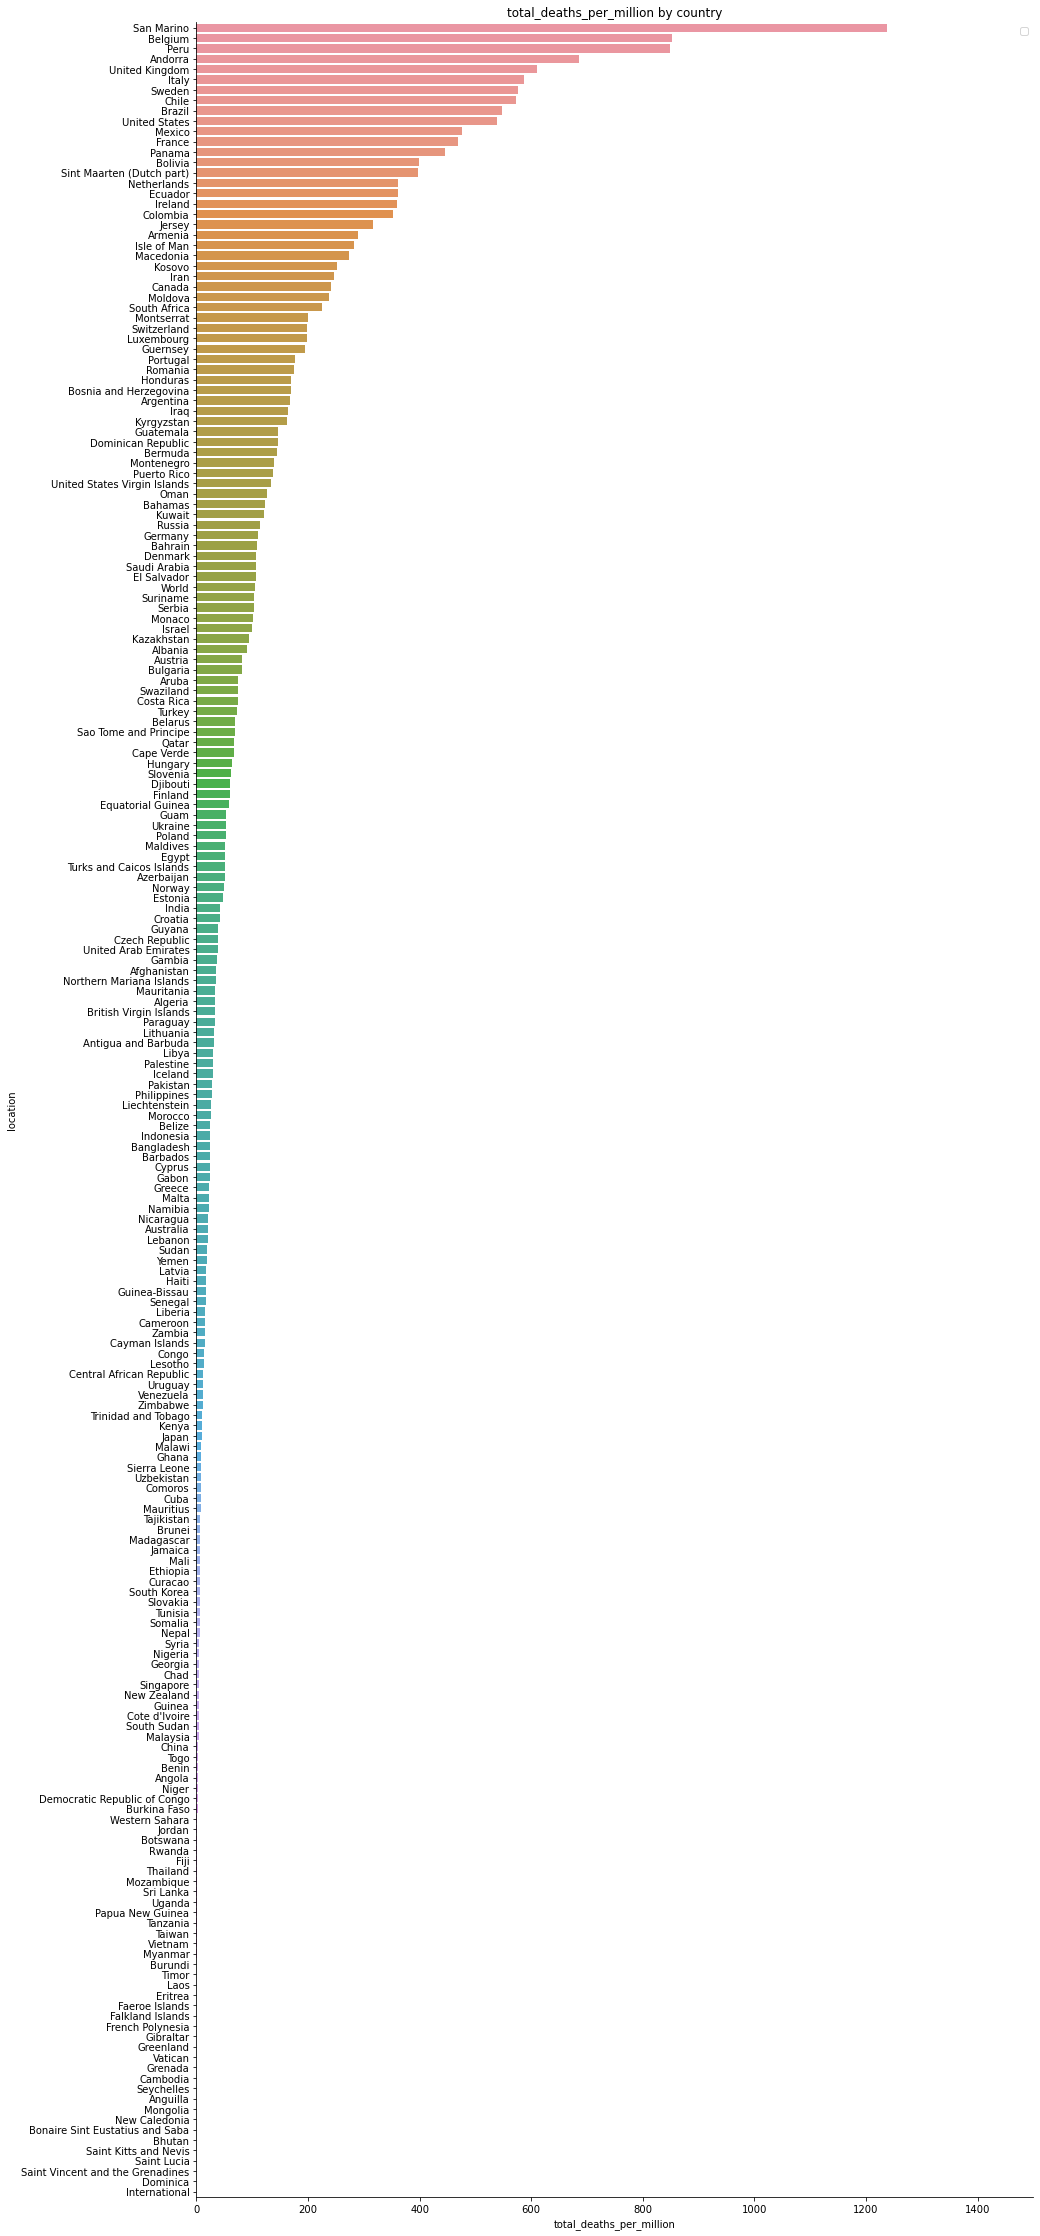

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

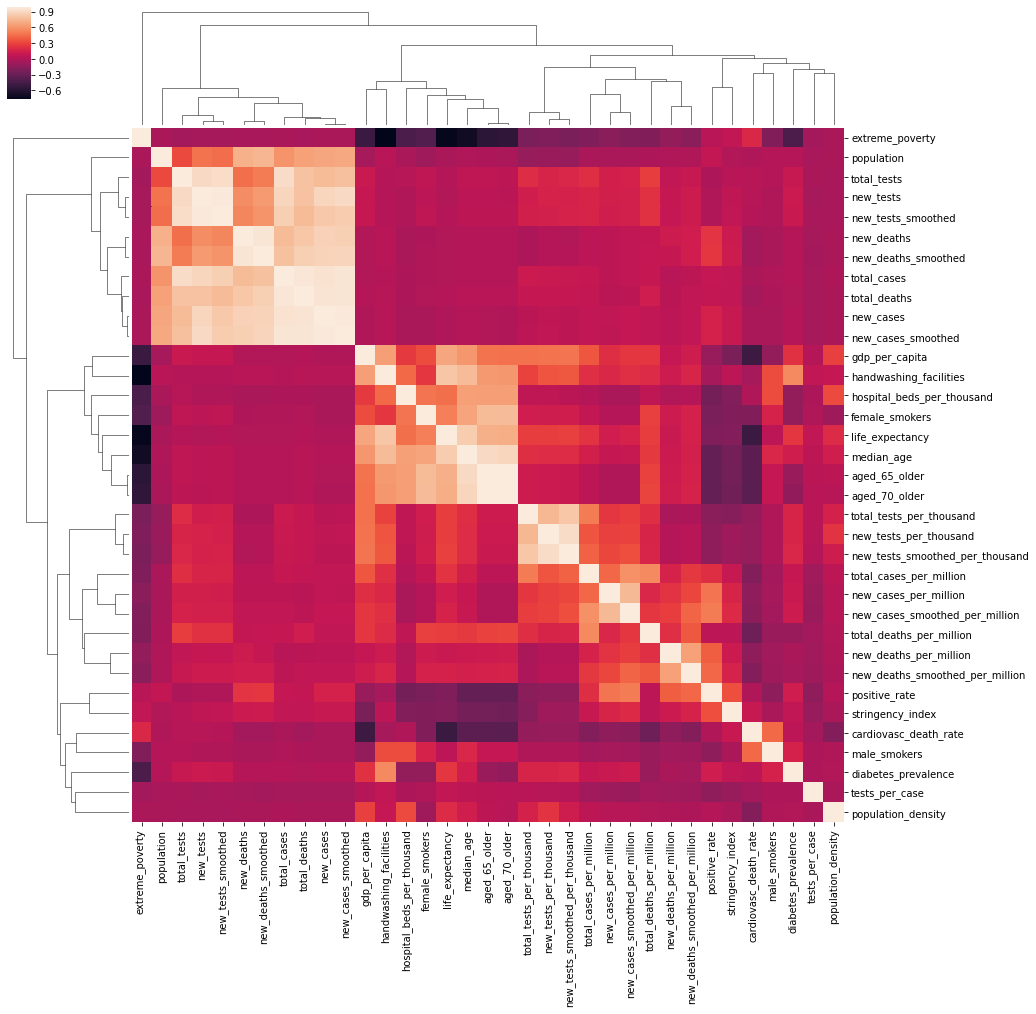

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994725545606684 (+/- 0.0003839703235843188)
Coef :  [1.03908297e+00 9.16478668e-05 9.79876434e-05]
3 Last_days :  [[23461327 23681358 23928539]]
Today :  23928539
Prediction + :  531315
Tomorow :  24459854
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996392799042536 (+/- 2.520737645838966e-05)
Coef :  [-0.00606067  0.49027117  0.52583935]
3 Last_days :  [[808893 813434 819756]]
Today :  819756
Prediction + :  7605
Tomorow :  827361
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9887264826377722 (+/- 0.008606860917329965)
Coef :  [-0.67804663  0.74185077  0.93760538]
3 Last_days :  [[242899 244854 248158]]
Today :  248158
Prediction + :  1745
Tomorow :  249903
                                     
--------- Total Death -----------------
                                     
R^2: 0.3691067388892675 (+/- 0.879406142679872)
Coef :  [-0.75356818  0.78860389  0.96403481]
3 Last_days :  [[30513 30528 30544]]
Today :  30544
Prediction + :  34
Tomorow :  30578
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8806910207009385 (+/- 0.08892247069497114)
Coef :  [-0.32362465 -0.02168937  1.33958399]
3 Last_days :  [[89695 89718 89752]]
Today :  89752
Prediction + :  33
Tomorow :  89785
                                     
--------- Total Death -----------------
                                     
R^2: -357.14026476816235 (+/- 506.30657383717846)
Coef :  [-0.07687006  0.01242662  1.05639872]
3 Last_days :  [[4711 4711 4712]]
Today :  4712
Prediction + :  6
Tomorow :  4718
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.33856574000959117 (+/- 0.9342110619076859)
Coef :  [-0.83159816  0.90202782  0.92880457]
3 Last_days :  [[259345 260298 261174]]
Today :  261174
Prediction + :  909
Tomorow :  262083
                                     
--------- Total Death -----------------
                                     
R^2: 0.9093514327417481 (+/- 0.10201740183968226)
Coef :  [-0.83140591  0.90096126  0.92959434]
3 Last_days :  [[35437 35441 35445]]
Today :  35445
Prediction + :  25
Tomorow :  35470
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7684537743363077 (+/- 0.31645659821911654)
Coef :  [-0.62015981  0.45682383  1.16488952]
3 Last_days :  [[386054 405436 412553]]
Today :  412553
Prediction + :  14033
Tomorow :  426586
                                     
--------- Total Death -----------------
                                     
R^2: 0.21103828380092618 (+/- 0.9456477473396143)
Coef :  [-0.72173112  0.61826334  1.1024756 ]
3 Last_days :  [[28838 28872 28924]]
Today :  28924
Prediction + :  38
Tomorow :  28962
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.992256657812364 (+/- 0.010718429495593486)
Coef :  [0.06755461 0.46894194 0.48060878]
3 Last_days :  [[5702611 5740909 5779028]]
Today :  5779028
Prediction + :  88333
Tomorow :  5867361
                                     
--------- Total Death -----------------
                                     
R^2: 0.4572370238328094 (+/- 0.7654679521201991)
Coef :  [-0.5768247   0.74604443  0.8331943 ]
3 Last_days :  [[176806 177279 178486]]
Today :  178486
Prediction + :  791
Tomorow :  179277
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9884986977872244 (+/- 0.015086283074649876)
Coef :  [-0.75833129  0.86606802  0.89236603]
3 Last_days :  [[325642 326614 327798]]
Today :  327798
Prediction + :  1117
Tomorow :  328915
                                     
--------- Total Death -----------------
                                     
R^2: 0.4090732322556933 (+/- 0.804739336244737)
Coef :  [-0.77428518  0.83232331  0.94141302]
3 Last_days :  [[41429 41433 41449]]
Today :  41449
Prediction + :  40
Tomorow :  41489
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9862059680164298 (+/- 0.01713839370650435)
Coef :  [-0.80340783  0.86023754  0.9428324 ]
3 Last_days :  [[233575 234853 236429]]
Today :  236429
Prediction + :  1157
Tomorow :  237586
                                     
--------- Total Death -----------------
                                     
R^2: 0.4134377386585295 (+/- 0.8180503417919265)
Coef :  [-0.79390797  0.84180777  0.95145714]
3 Last_days :  [[9272 9277 9280]]
Today :  9280
Prediction + :  10
Tomorow :  9290
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.9602766781693287 (+/- 2.771222764307279)
Coef :  [0.19559523 0.40417348 0.41214509]
3 Last_days :  [[358905 358905 361150]]
Today :  361150
Prediction + :  4248
Tomorow :  365398
                                     
--------- Total Death -----------------
                                     
R^2: 0.8977037414674124 (+/- 0.14405868518925866)
Coef :  [-0.01287279  0.50969159  0.51580076]
3 Last_days :  [[20643 20643 20776]]
Today :  20776
Prediction + :  243
Tomorow :  21019
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9979650627328974 (+/- 0.0025903328529654195)
Coef :  [-0.7468418   0.85263737  0.89148604]
3 Last_days :  [[258249 259692 261194]]
Today :  261194
Prediction + :  1208
Tomorow :  262402
                                     
--------- Total Death -----------------
                                     
R^2: 0.9990967394098437 (+/- 0.0009645832621490742)
Coef :  [-0.81508296  0.89669969  0.91536706]
3 Last_days :  [[6121 6139 6163]]
Today :  6163
Prediction + :  16
Tomorow :  6179
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4584092186374447 (+/- 0.7613225969149721)
Coef :  [-0.18668059  0.50149893  0.70126345]
3 Last_days :  [[3605783 3622861 3669995]]
Today :  3669995
Prediction + :  52874
Tomorow :  3722869
                                     
--------- Total Death -----------------
                                     
R^2: 0.49733976267917285 (+/- 0.7031368458025677)
Coef :  [-0.15512204  0.53289538  0.63492175]
3 Last_days :  [[114744 115309 116580]]
Today :  116580
Prediction + :  1323
Tomorow :  117903
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(23928539, 819756, 24459854, 827361),
 (248158, 30544, 249903, 30578),
 (261174, 35445, 262083, 35470),
 (412553, 28924, 426586, 28962),
 (5779028, 178486, 5867361, 179277),
 (89752, 4712, 89785, 4718),
 (327798, 41449, 328915, 41489),
 (236429, 9280, 237586, 9290),
 (361150, 20776, 365398, 21019),
 (261194, 6163, 262402, 6179),
 (3669995, 116580, 3722869, 117903)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-26,France,249903.0,0.0,30578.0,0.0,0.0,0.0
0,2020-08-26,China,89785.0,0.0,4718.0,0.0,0.0,0.0
0,2020-08-26,Italy,262083.0,0.0,35470.0,0.0,0.0,0.0
0,2020-08-26,Spain,426586.0,0.0,28962.0,0.0,0.0,0.0
0,2020-08-26,United States,5867361.0,0.0,179277.0,0.0,0.0,0.0
0,2020-08-26,World,24459854.0,0.0,827361.0,0.0,0.0,0.0
0,2020-08-26,United Kingdom,328915.0,0.0,41489.0,0.0,0.0,0.0
0,2020-08-26,Germany,237586.0,0.0,9290.0,0.0,0.0,0.0
0,2020-08-26,Iran,365398.0,0.0,21019.0,0.0,0.0,0.0
0,2020-08-26,Turkey,262402.0,0.0,6179.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")